<a href="https://colab.research.google.com/github/jaramillooo/Proyecto_series_no_lineales/blob/main/proyecto12ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Demand Forecasting Orders
 [Dataset link](https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders).


Variables:
- Week of the month	Feature	Integer	(first, second, third, fourth or fifth week)
- Day of the week	Feature	Integer	(Monday to Friday)
- Non-urgent order	Feature	Continuous
- Urgent order	Feature	Continuous
- Order type A	Feature	Continuous
- Order type B	Feature	Continuous
- Order type C	Feature	Continuous
- Fiscal sector orders	Feature	Continuous
- Orders from the traffic controller sector	Feature	Integer
- Banking orders (1)	Feature	Integer

The dataset was collected during 60 days, this is a real database of a brazilian logistics company. The dataset has twelve predictive attributes and a target that is the total of orders for daily treatment. The database was used in academic research at the Universidade Nove de Julho.
.arff header for Weka:

@relation Daily_Demand_Forecasting_Orders

Week_of_the_month {1.0, 2.0, 3.0, 4.0, 5.0}

Day_of_the_week_(Monday_to_Friday) {2.0, 3.0, 4.0, 5.0, 6.0}

Non_urgent_order integer

Urgent_order integer

Order_type_A integer

Order_type_B integer

Order_type_C integer

Fiscal_sector_orders integer

Orders_from_the_traffic_controller_sector integer

Banking_orders_(1) integer

Banking_orders_(2) integer

Banking_orders_(3) integer

Target_(Total_orders) integer


In [ ]:
pip install ucimlrepo

In [10]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# dataset
daily_demand_forecasting_orders = fetch_ucirepo(id=409)
X = daily_demand_forecasting_orders.data.features
y = daily_demand_forecasting_orders.data.targets
print(daily_demand_forecasting_orders.metadata),print(daily_demand_forecasting_orders.variables)

{'uci_id': 409, 'name': 'Daily Demand Forecasting Orders', 'repository_url': 'https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders', 'data_url': 'https://archive.ics.uci.edu/static/public/409/data.csv', 'abstract': 'The dataset was collected during 60 days, this is a real database of a brazilian logistics company.', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Time-Series'], 'num_instances': 60, 'num_features': 12, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Total orders'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C5BC8T', 'creators': ['Ricardo Ferreira', 'Andrea Martiniano', 'Arthur Ferreira', 'Aleister Ferreira', 'Renato Sassi'], 'intro_paper': {'title': 'Study on Daily Demand Forecasting Orders using Artificial Neural Network', 'authors': 'R. P. Ferreira, Andréa Martiniano, Arthur Arruda Leal 

(None, None)

In [ ]:
X['Datetime'] = pd.to_datetime((X['Week of the month'] - 1) * 7 + X['Day of the week'] - 2, unit='D', origin='2022-01-01')
# adjust the date range to 60 days
X['Datetime'] = X['Datetime'] - pd.Timedelta(days=60)
ds = X.copy()
X.set_index('Datetime', inplace=True)
X.drop(['Day of the week', 'Week of the month'], axis=1, inplace=True)

In [ ]:
X.dtypes

Non-urgent order                             float64
Urgent order                                 float64
Order type A                                 float64
Order type B                                 float64
Order type C                                 float64
Fiscal sector orders                         float64
Orders from the traffic controller sector      int64
Banking orders (1)                             int64
Banking orders (2)                             int64
Banking orders (3)                             int64
dtype: object

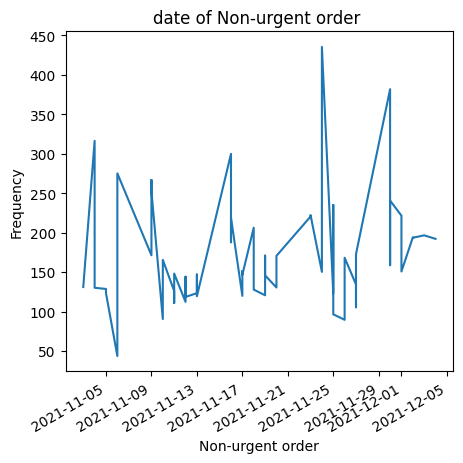

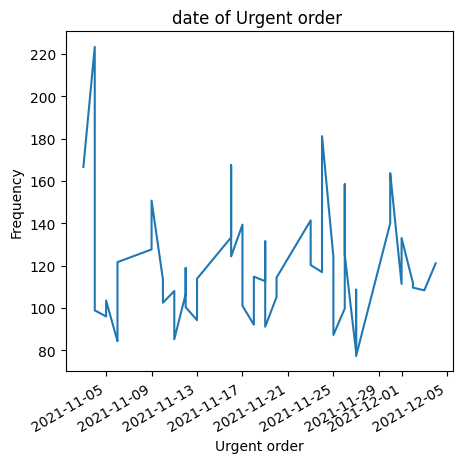

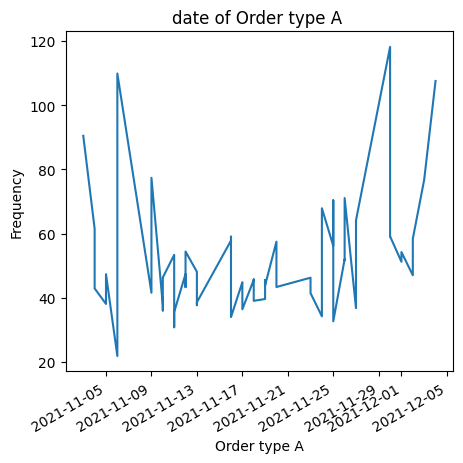

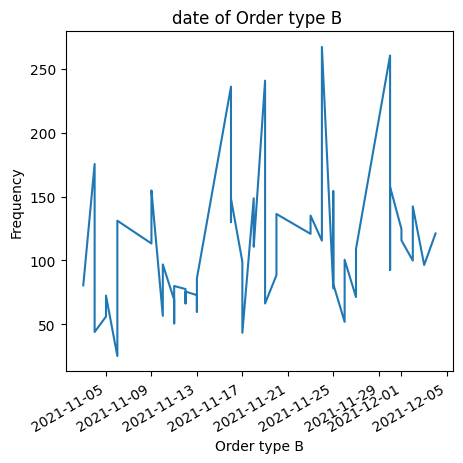

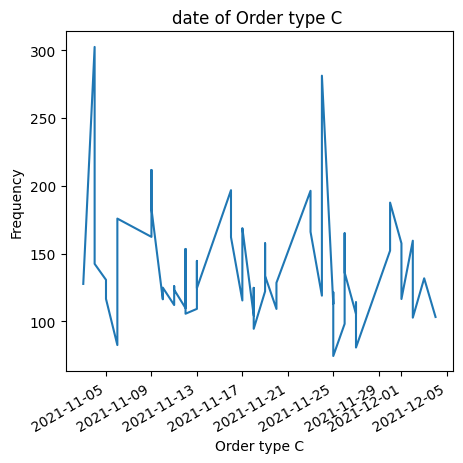

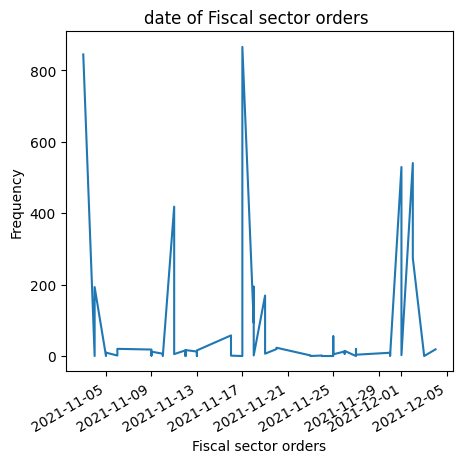

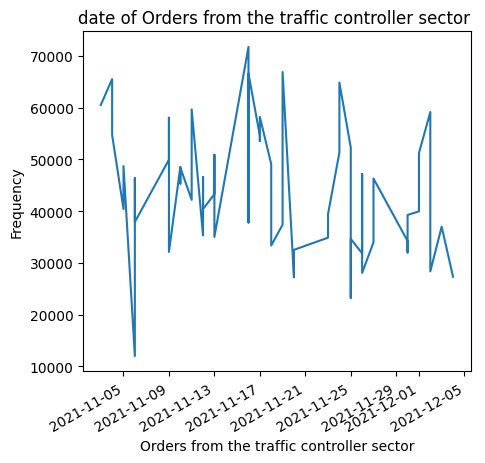

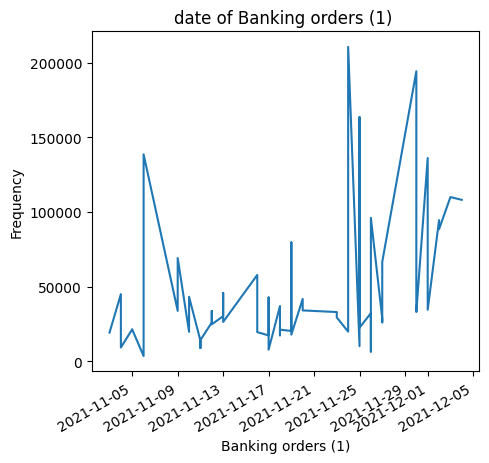

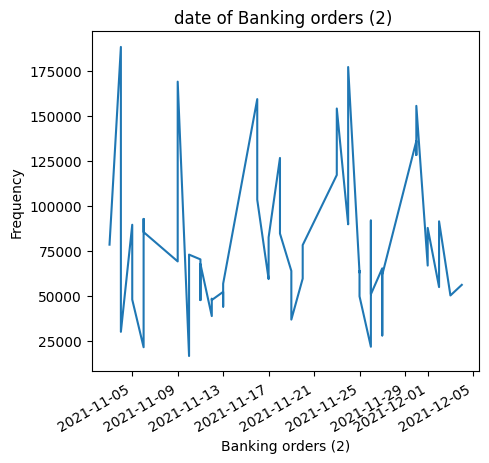

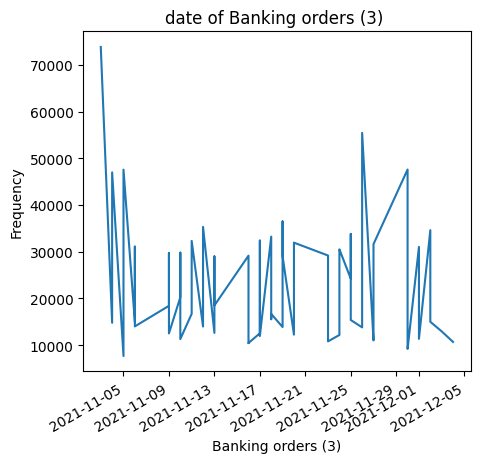

In [ ]:
columns_to_plot = [col for col in X.columns if col != 'Datetime']
for col in columns_to_plot:
    plt.figure(figsize=(5, 5))
    X[col].plot()
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"date of {col} ")
    plt.show()

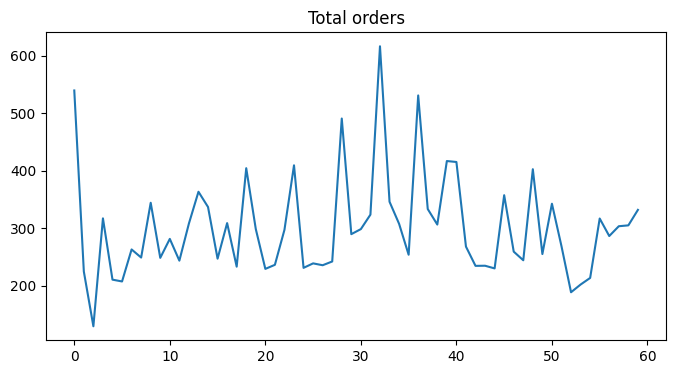

In [ ]:
y['Total orders'].plot(kind='line', figsize=(8, 4), title='Total orders')
plt.gca().spines[['top', 'right']].set_visible(True)

In [ ]:
_ = pd.DataFrame({
    'Datetime': ds['Datetime'],
    'Total orders': y['Total orders']
})
data = _.set_index('Datetime')
data.head(10)

,Total orders
Datetime,
2021-11-04,539.577
2021-11-05,224.675
2021-11-06,129.412
2021-11-09,317.120
2021-11-10,210.517
2021-11-11,207.364
2021-11-12,263.043
2021-11-13,248.958
2021-11-16,344.291


<Axes: xlabel='Datetime'>

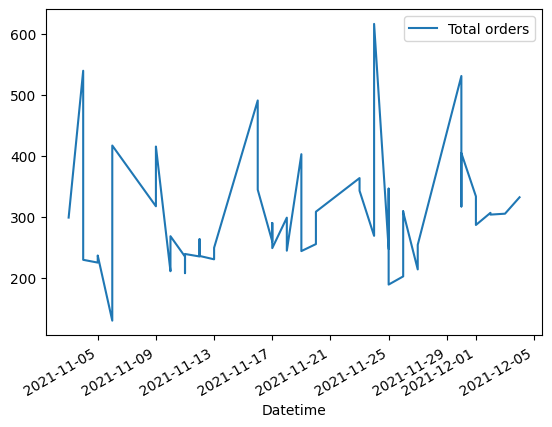

In [ ]:
data.plot()

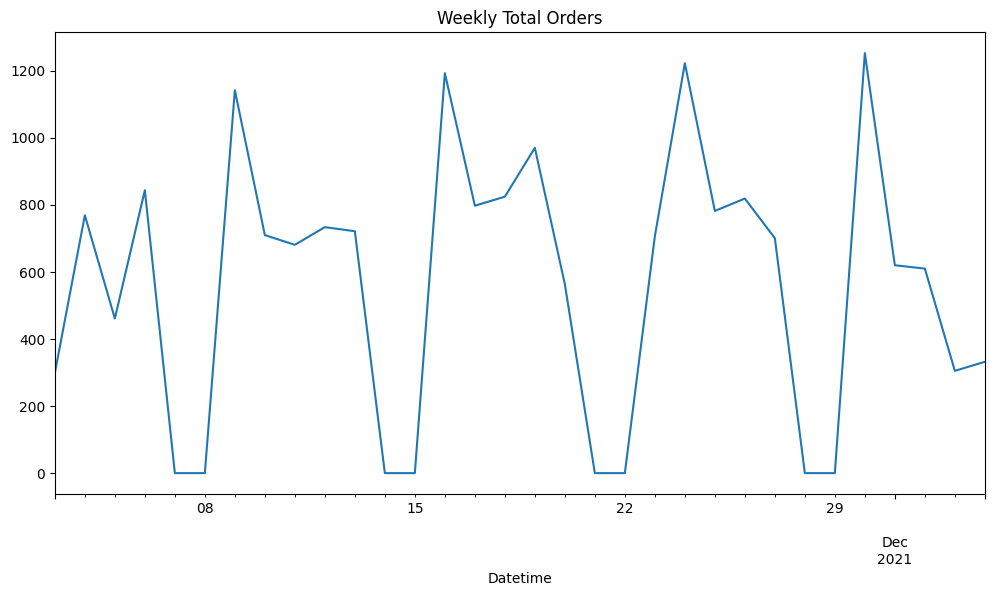

In [ ]:

days = data.resample('D')['Total orders'].sum()
days.plot(figsize=(12, 6))
plt.title('Weekly Total Orders')
plt.show()

In [ ]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO

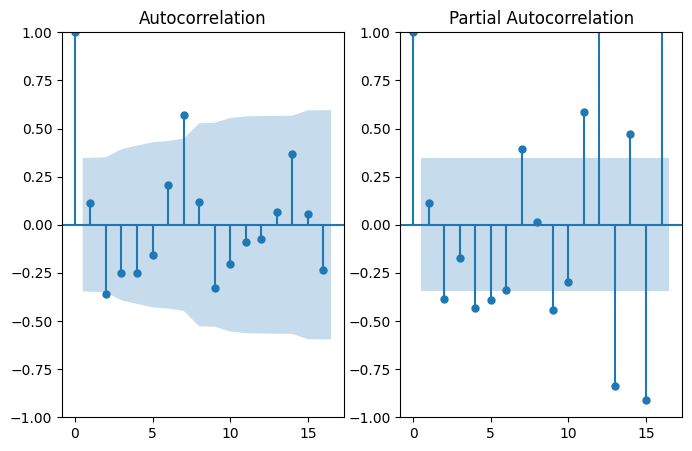

In [ ]:
# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(days, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(days, ax=ax2, method='ols')

plt.show()

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
adf_test(days)

Results of Dickey-Fuller Test:
Test Statistic                 -1.507899
p-value                         0.529600
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
Non-stationary


In [ ]:
adf_test(days.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.537604e+00
p-value                        9.981672e-14
#Lags Used                     5.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64
Stationary


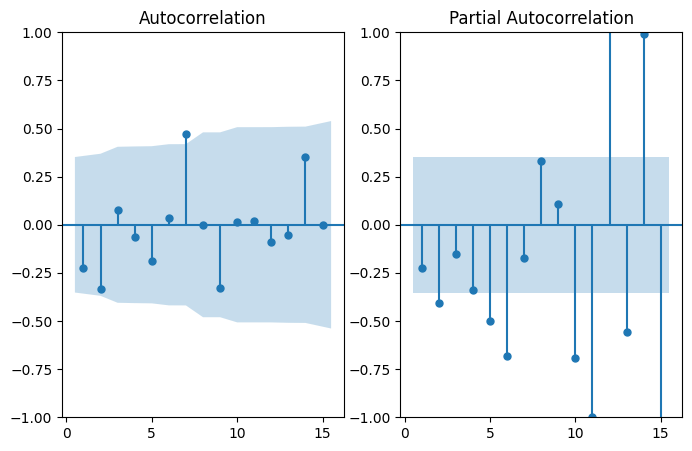

In [ ]:

def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(days.diff().dropna(), {'lags':15})

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model1 = ARIMA(days, order=(8, 2, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:           Total orders   No. Observations:                   32
Model:                 ARIMA(8, 2, 2)   Log Likelihood                -215.061
Date:                Mon, 06 May 2024   AIC                            452.121
Time:                        00:27:12   BIC                            467.534
Sample:                    11-03-2021   HQIC                           457.052
                         - 12-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9630      1.915     -0.503      0.615      -4.717       2.791
ar.L2         -0.8633      2.629     -0.328      0.743      -6.015       4.288
ar.L3         -0.6913      2.980     -0.232      0.8

<Axes: xlabel='Datetime'>

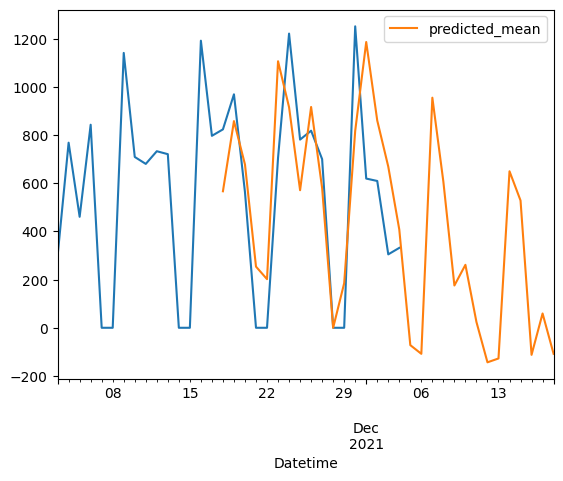

In [ ]:
y_h = model1.predict(start=15, end=45, dynamic=False).to_frame()

ax = days.plot()

y_h.plot(ax=ax)

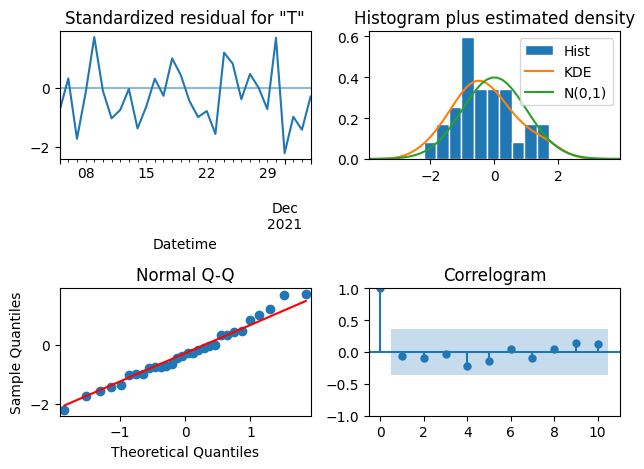

In [ ]:
model1.plot_diagnostics()
plt.tight_layout();

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                        SARIMAX   Log Likelihood                -236.859
Date:                Mon, 06 May 2024   AIC                            477.718
Time:                        01:44:11   BIC                            480.650
Sample:                    11-03-2021   HQIC                           478.690
                         - 12-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    564.1375     70.744      7.974      0.000     425.482     702.793
sigma2      1.573e+05   5.72e+04      2.749      0.006    4.51e+04    2.69e+05
Ljung-Box (L1) (Q):                   0.45   Jarque-

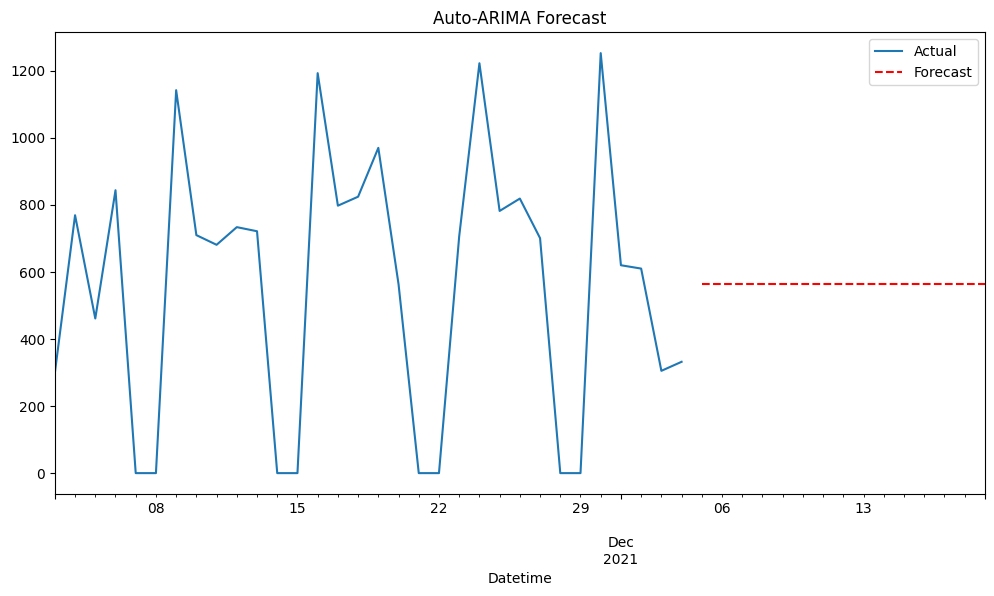

In [ ]:
import pandas as pd
import pmdarima as pm
from pmdarima import model_selection

model = pm.auto_arima(days, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
print(model.summary())
forecast = model.predict(n_periods=15)
days.plot(figsize=(12, 6), label='Actual')
forecast.plot(color='red', linestyle='--', label='Forecast')
plt.legend()
plt.title('Auto-ARIMA Forecast')
plt.show()



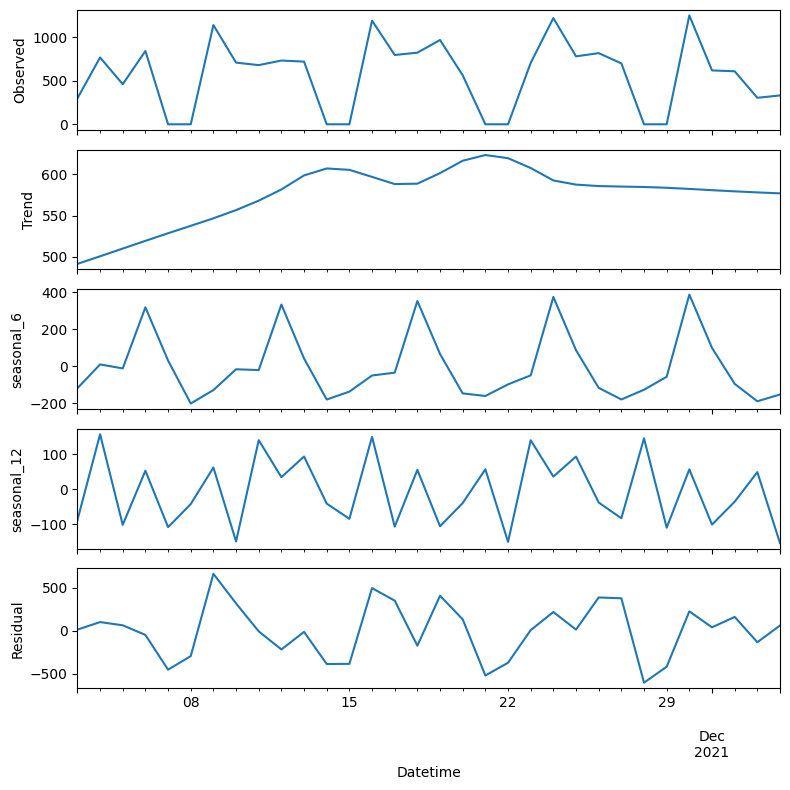

In [ ]:
# Función para análisis de estacionalidad
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

periods_seasonality = (6,12)

stl_kwargs = {"seasonal_deg": 0}
model = MSTL(days, periods=(periods_seasonality), stl_kwargs=stl_kwargs)
res2 = model.fit()

# Gráfica de descomposición
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

res2.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

res2.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

res2.resid.plot(ax=ax[4])
ax[4].set_ylabel('Residual')

fig.tight_layout()

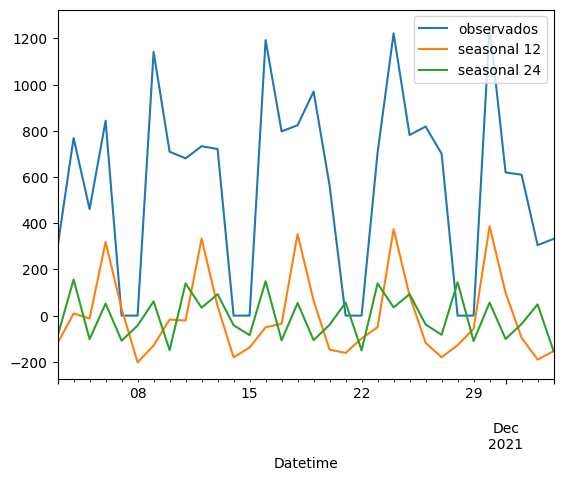

In [ ]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed.plot(label='observados')

res2.seasonal['seasonal_6'].plot(ax=ax, label='seasonal 12')
res2.seasonal['seasonal_12'].plot(ax=ax, label='seasonal 24')

plt.legend()
plt.show()

# Parte 3 Clasificación

Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

Dataset Characteristics
Multivariate, Time-Series

Associated Tasks
Classification

Feature Type: Real

- Instances
20560

- Features
6

| Variable | Role | Type | Description | Units | Missing Values |
| --- | --- | --- | --- | --- | --- |
| id | ID | Integer |  |  | no |
| date | Feature | Date |  |  | no |
| Temperature | Feature | Integer |  |  | no |
| Humidity | Feature | Continuous |  | % | no |
| Light | Feature | Integer |  | Lux | no |

Variables information:

date time year-month-day hour:minute:second

Temperature, in Celsius

Relative Humidity, %

Light, in Lux

CO2, in ppm

Humidity Ratio, Derived quantity from temperature and relative humidity, in
kgwater-vapor/kg-air

Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status



In [47]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
occupancy_detection = fetch_ucirepo(id=357)

# data (as pandas dataframes)
X = occupancy_detection.data.features
y = occupancy_detection.data.targets

# metadata
print(occupancy_detection.metadata)

# variable information
print(occupancy_detection.variables)


{'uci_id': 357, 'name': 'Occupancy Detection ', 'repository_url': 'https://archive.ics.uci.edu/dataset/357/occupancy+detection', 'data_url': 'https://archive.ics.uci.edu/static/public/357/data.csv', 'abstract': 'Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 20560, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Occupancy'], 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Sat Apr 13 2024', 'dataset_doi': '10.24432/C5X01N', 'creators': ['Luis Candanedo'], 'intro_paper': {'title': 'Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistic

In [48]:
X.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518


In [51]:
numeric_cols = [col for col in X.columns if col!= 'date']
X[numeric_cols] = X[numeric_cols].apply(pd.to_numeric, errors='coerce')
X.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
dtype: object

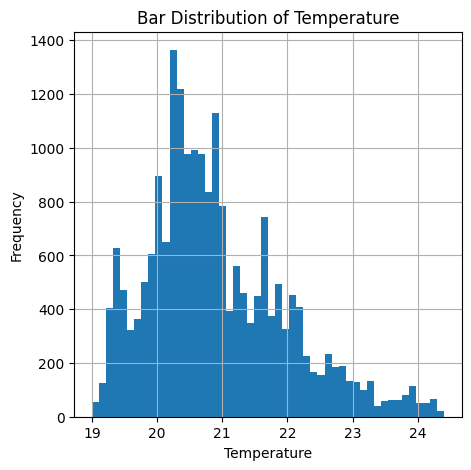

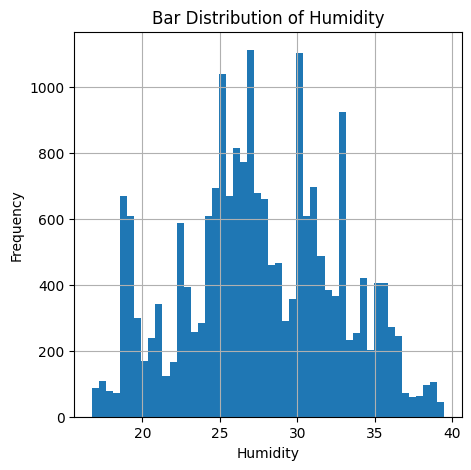

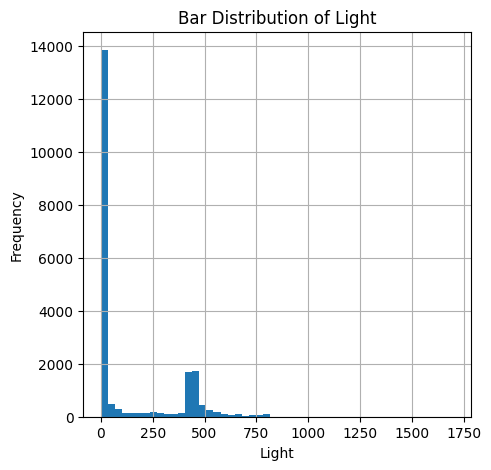

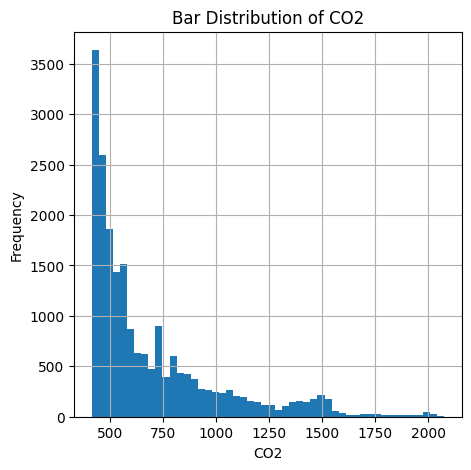

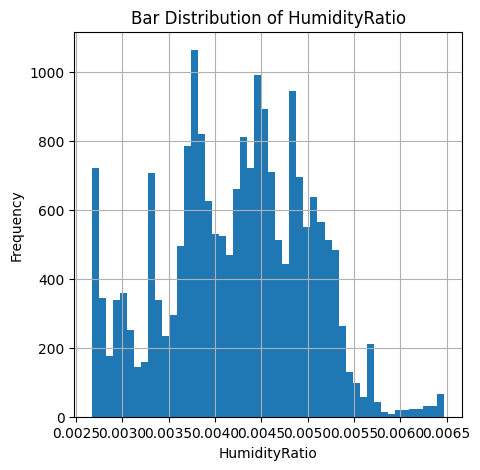

In [29]:
for col in columns_to_plot:
    if X[col].dtype.kind in 'bifc':
        plt.figure(figsize=(5, 5))
        X[col].hist(bins=50)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Bar Distribution of {col}")
        plt.show()

In [52]:
from sklearn.preprocessing import StandardScaler
X_df = pd.DataFrame(X)
numeric_cols = X_df.select_dtypes(include=['int64','float'])
StandardScaler = StandardScaler()
X_scaled = pd.DataFrame(StandardScaler.fit_transform(numeric_cols), columns=numeric_cols.columns)

In [64]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [68]:
X_numeric = X.drop('date', axis=1)
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)
X_scaled = pd.concat([X[['date']], X_scaled_df], axis=1)

In [66]:
X.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-04 17:51:00,1.871698,-0.002651,1.415282,0.452128,0.450322
1,2015-02-04 17:51:59,1.849057,-0.003314,1.426910,0.431093,0.441743
2,2015-02-04 17:53:00,1.849057,-0.006627,1.415282,0.429642,0.438168
3,2015-02-04 17:54:00,1.849057,-0.013255,1.415282,0.414410,0.431019
4,2015-02-04 17:55:00,1.811321,-0.013255,1.415282,0.403530,0.417974


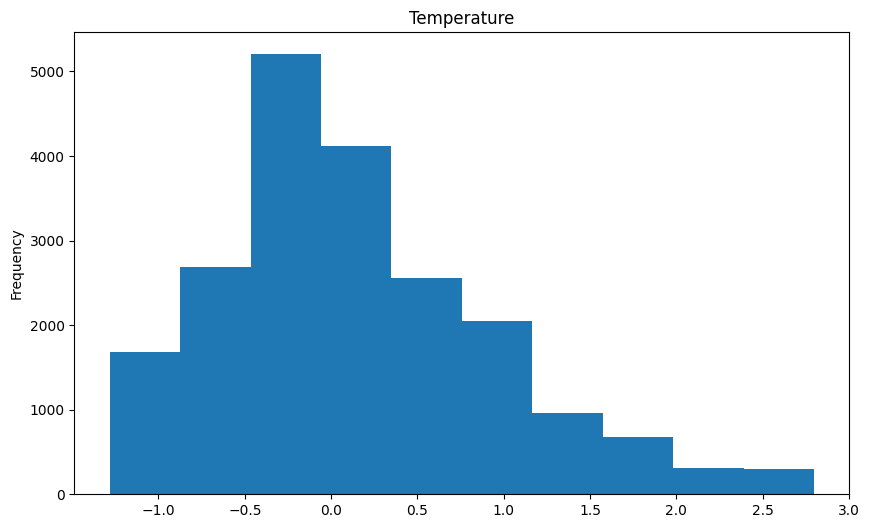

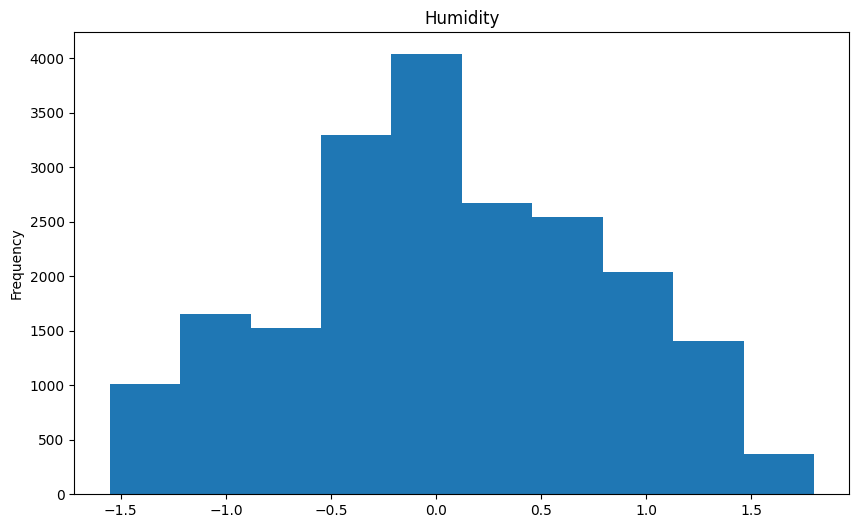

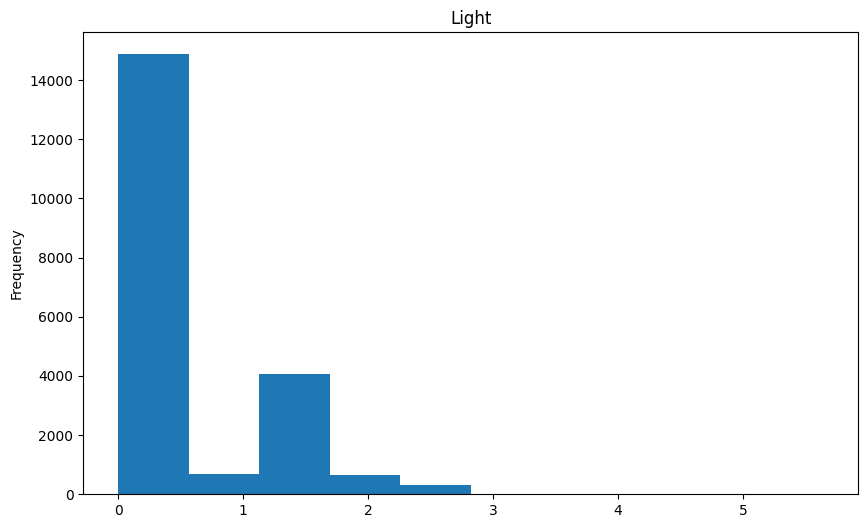

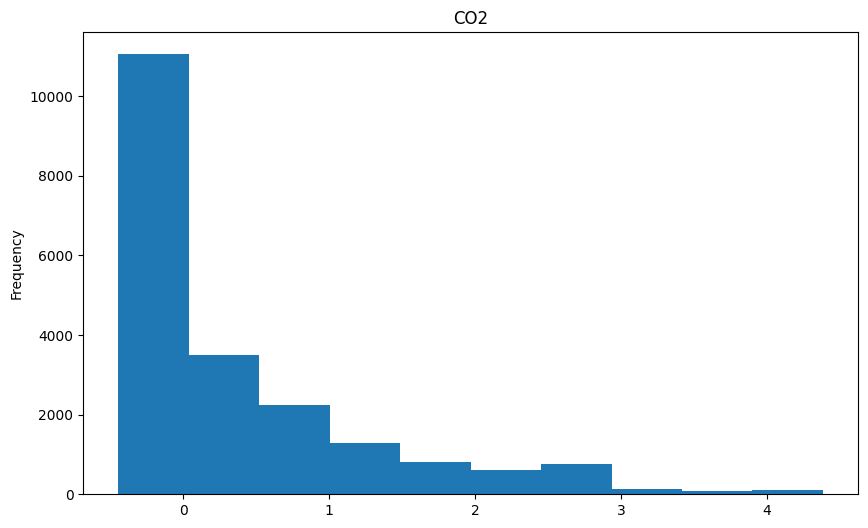

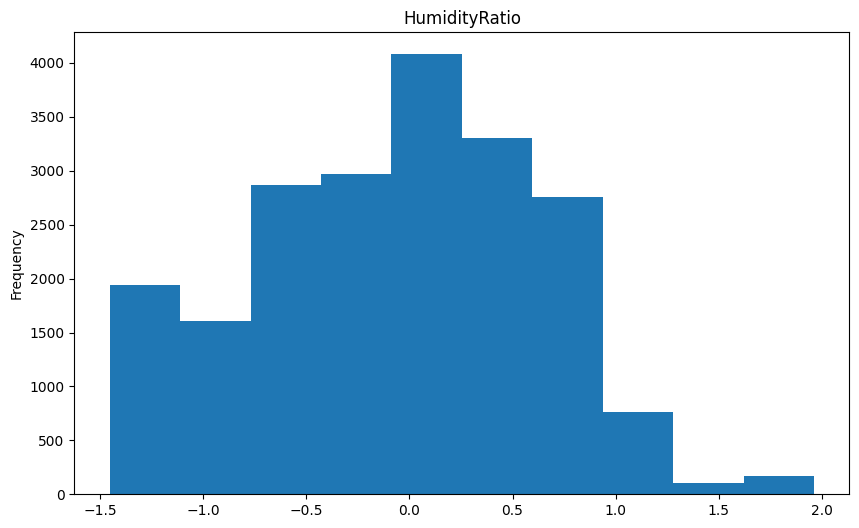

In [69]:
for col in X_scaled.columns:
    if col!= 'date':
        plt.figure(figsize=(10, 6))
        X_scaled[col].plot(kind='hist')
        plt.title(col)
        plt.show()

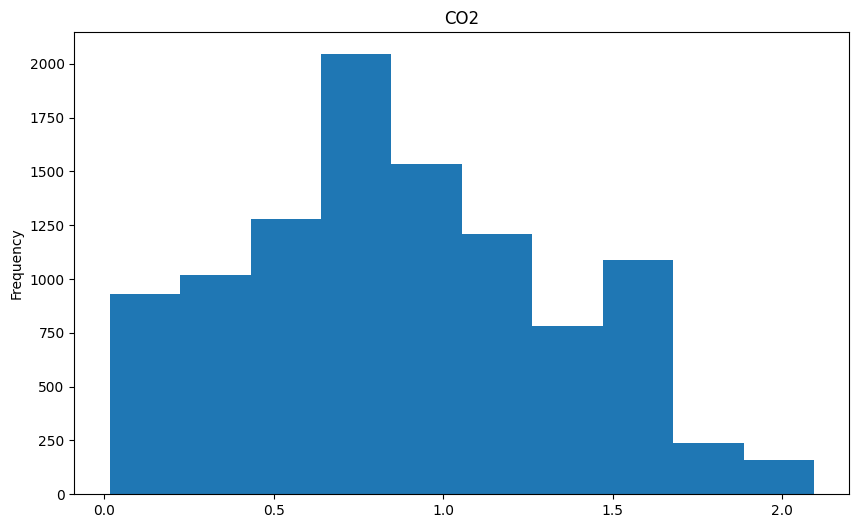

In [78]:
co2_sqrt = np.sqrt(X_scaled["CO2"])
# plot the transformed data
plt.figure(figsize=(10, 6))
co2_sqrt.plot(kind='hist')
plt.title("CO2")
plt.show()

In [ ]:
co2_sqrt = X_scaled['C02']

In [86]:
from statsmodels.stats.diagnostic import kstest_normal

log_transformed = np.log(X['CO2'].values + 1)
print(log_transformed)
_, p = kstest_normal(co2_sqrt)  # stats.normaltest
print(f"significance: {p,_}")

[0.37302983 0.35843838 0.35742418 ... 1.32811853 1.40965335 1.5618535 ]
significance: (nan, nan)


In [90]:
from sklearn.preprocessing import power_transform
co2_sqrt = np.array(co2_sqrt)
vals_bc = power_transform(co2_sqrt.reshape(-1, 1), method='box-cox')

_, p = kstest_normal(vals_bc.squeeze())
print(f"significance: {p:.2f}")

significance: nan
